Кравчук Євгеній, Малик Дмитро

### 1.1 Дослідження роботи алгоритмів Прима та Крускала

У данному експерименті ми досліджуємо роботу алгоритмів Мінімального каркаса графа: Прима та Крускала. Для цього ми використовуємо скрипт, що генерує довільний зв’язний граф з заданою кількістю вершин та ймовірністю провести ребро між вершинами. Дослідження проводиться для різних розмірів графа та різних ймовірностей проведення ребер.

### Імпорт та необхідні функції 

In [42]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, groupby
import time
from tqdm import tqdm
from networkx.algorithms import tree
from networkx.algorithms import floyd_warshall_predecessor_and_distance
from networkx.algorithms import bellman_ford_predecessor_and_distance

In [43]:
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()

    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)

        
    return G

In [44]:
def draw_graph(graph):
    plt.figure(figsize=(10,6))
    if isinstance(graph, nx.DiGraph):
        # draw with edge weights
        pos = nx.spring_layout(graph)
        nx.draw(graph,pos, node_color='lightblue', 
                with_labels=True,
                node_size=500, 
                arrowsize=20, 
                arrows=True)
        labels = nx.get_edge_attributes(graph,'weight')
        nx.draw_networkx_edge_labels(graph, pos,edge_labels=labels)
        
    else:
        pos = nx.spring_layout(graph)
        nx.draw(graph,pos, node_color='lightblue', 
                with_labels=True,
                node_size=500)
        labels = nx.get_edge_attributes(graph,'weight')
        nx.draw_networkx_edge_labels(graph, pos,edge_labels=labels)

In [45]:
def count_time(function, size):
    time_taken = 0
    for _ in tqdm(range(100)):

        # note that we should not measure time of graph creation
        G = gnp_random_connected_graph(size, 0.4, False)

        start = time.time()
        function(G)
        end = time.time()

        time_taken += end - start

    return time_taken / 100

### Алгоритм Краскала

In [46]:
G = gnp_random_connected_graph(5, 0.5, False)

In [47]:
def kruskal_algo(graph):
    minimum_tree = nx.Graph()
    sorted_edges = sorted(graph.edges(data=True), key=lambda x: x[2]['weight'])

    disjoint_set_union = nx.utils.UnionFind()

    for edge in sorted_edges:
        node_u, node_v, weight = edge
        if disjoint_set_union[node_u] != disjoint_set_union[node_v]:
            minimum_tree.add_edge(node_u, node_v, weight=weight['weight'])
            disjoint_set_union.union(node_u, node_v)
    return minimum_tree

In [48]:
def default_kruskal(graph):
    return tree.minimum_spanning_tree(graph, algorithm="kruskal")

In [49]:
prog_krusk_mst = kruskal_algo(G)
print(type(prog_krusk_mst.edges))

<class 'networkx.classes.reportviews.EdgeView'>


Перевірка на правильність

In [50]:
right_list = []
for i in range(1000):
    G = gnp_random_connected_graph(5, 0.5, False)
    prog_krusk_mst = kruskal_algo(G)
    default_krusk_mst = default_kruskal(G)
    set_one = set()
    set_two = set()
    for i in range(len(prog_krusk_mst.edges)):
        set_one.add(list(prog_krusk_mst.edges)[i])
        set_one.add(list(prog_krusk_mst.edges)[i][::-1])
        set_two.add(list(default_krusk_mst.edges)[i])
        set_two.add(list(default_krusk_mst.edges)[i][::-1])
    right_list.append(set_one == set_two)

f"Right in a {int(right_list.count(True)/len(right_list)*100)}% of cases"

'Right in a 100% of cases'

В результаті цього експерименту, ми можемо бачити, що алгоритми видають однакивий результат

Порівняння швидкості

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 225.90it/s]


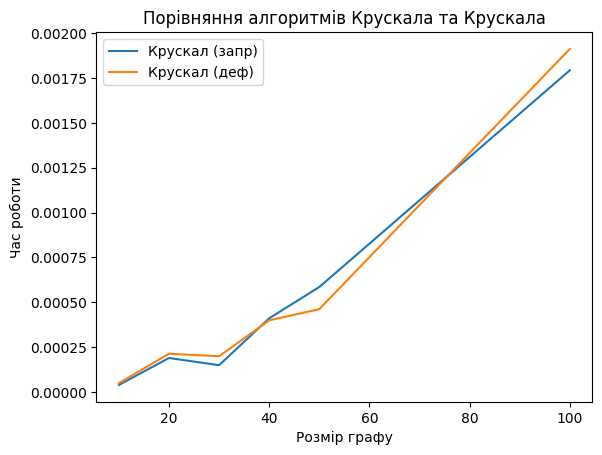

In [51]:
graph_sizes = [10, 20, 30, 40, 50, 100]
kruskal_times_prog = [count_time(kruskal_algo, size) for size in graph_sizes]  # Приклад часу роботи для алгоритму Крускала (запрограмованого)
kruskal_times_def = [count_time(default_kruskal, size) for size in graph_sizes]  # Приклад часу роботи для алгоритму Крускала (дефолтного)

plt.plot(graph_sizes, kruskal_times_prog, label='Крускал (запр)')
plt.plot(graph_sizes, kruskal_times_def, label='Крускал (деф)')
plt.xlabel('Розмір графу')
plt.ylabel('Час роботи')
plt.title('Порівняння алгоритмів Крускала та Крускала')
plt.legend()
plt.show()

В результаті цього експерименту, ми можемо бачити, що алгоритми майють майже однакові показники швидкості обробки інформації

### Алгоритм Прима

In [52]:
G = gnp_random_connected_graph(5, 0.5, False)

In [53]:
def convert_to_matrix_for_prim(graph):
    directed = isinstance(graph, nx.DiGraph)
    edge_weights = nx.get_edge_attributes(graph, 'weight')
    matrix = [[0 for i in range(len(graph.nodes))] for j in range(len(graph.nodes))]

    if not directed:
        edge_weights_copy = dict()
        for edge in edge_weights:
            edge_weights_copy[edge] = edge_weights[edge]
            edge_weights_copy[edge[::-1]] = edge_weights[edge]

        edge_weights = edge_weights_copy

    for edge in edge_weights:
        matrix[edge[0]][edge[1]] = edge_weights[edge]

    return matrix

In [54]:
def prims_algorithm(graph):

    mst = nx.Graph()

    num_nodes = len(graph)
    infinity = float('inf')
    selected = [0] * num_nodes
    selected[0] = True
    edge_count = 0
    adjacency_matrix = convert_to_matrix_for_prim(graph)
    weighted_edges = []

    while edge_count < num_nodes - 1:
        min_weight = []
        for i in range(num_nodes):
            if selected[i]:
                for j in range(num_nodes):
                    if not selected[j] and adjacency_matrix[i][j]:
                        min_weight.append((i, j, adjacency_matrix[i][j]))
        if len(weighted_edges) == 0:
            break
        weighted_edges.append(sorted(min_weight, key=lambda x: x[2])[0])
        selected[weighted_edges[-1][1]] = True
        edge_count += 1


    mst.add_weighted_edges_from(weighted_edges)
    return mst
    

In [55]:
def default_prim(graph):
    return tree.minimum_spanning_tree(graph, algorithm="prim")

Перевірка на правильність

In [56]:
right_list = []
for i in range(1000):
    G = gnp_random_connected_graph(20, 0.5, False)
    prog_prim_mst = prims_algorithm(G)
    default_prim_mst = default_prim(G)
    set_one = set()
    set_two = set()
    for i in range(len(prog_prim_mst.edges)):
        set_one.add(list(prog_prim_mst.edges)[i])
        set_one.add(list(prog_prim_mst.edges)[i][::-1])
        set_two.add(list(default_prim_mst.edges)[i])
        set_two.add(list(default_prim_mst.edges)[i][::-1])
    right_list.append(set_one == set_two)

f"Right in a {int(right_list.count(True)/len(right_list)*100)}% of cases"

'Right in a 100% of cases'

В результаті цього експерименту, ми можемо бачити, що алгоритми видають різний результат, це може бути пов'язаним з порядком вибору ребер

Порівняння швидкості

100%|██████████| 100/100 [00:00<00:00, 717.52it/s]


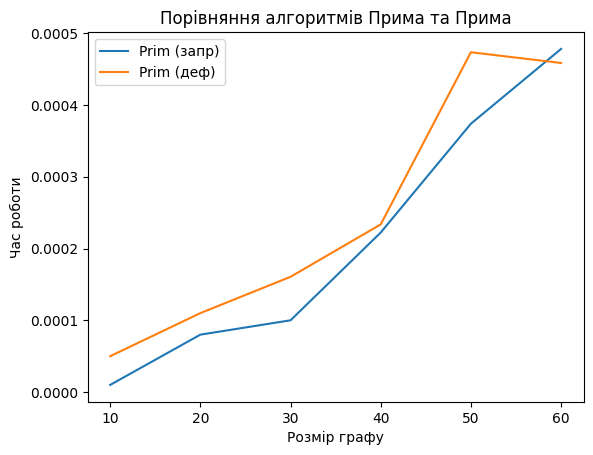

In [57]:
graph_sizes = [10, 20, 30, 40, 50, 60]
prim_times_prog = [count_time(prims_algorithm, size) for size in graph_sizes]  # Приклад часу роботи для алгоритму Крускала (запрограмованого)
prim_times_def = [count_time(default_prim, size) for size in graph_sizes]  # Приклад часу роботи для алгоритму Крускала (дефолтного)

plt.plot(graph_sizes, prim_times_prog, label='Prim (запр)')
plt.plot(graph_sizes, prim_times_def, label='Prim (деф)')
plt.xlabel('Розмір графу')
plt.ylabel('Час роботи')
plt.title('Порівняння алгоритмів Прима та Прима')
plt.legend()
plt.show()

В результаті цього експерименту, ми можемо бачити, що алгоритми сильно різняться в показниках швидкості

### Порівняння Прима і Краскала

100%|██████████| 100/100 [00:00<00:00, 11096.63it/s]


100%|██████████| 100/100 [00:00<00:00, 628.78it/s]


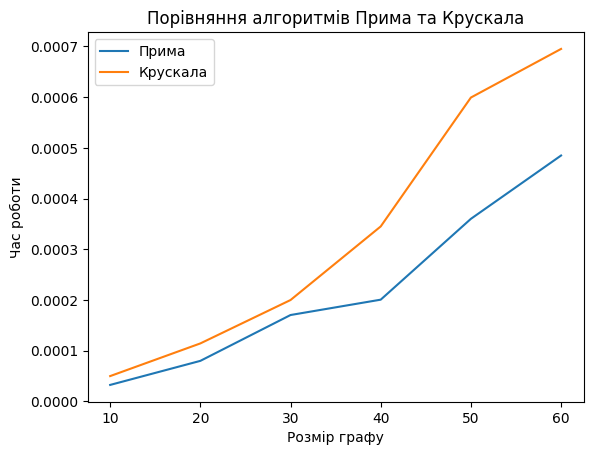

In [58]:
graph_sizes = [10, 20, 30, 40, 50, 60]
prim_times_comp = [count_time(default_prim, size) for size in graph_sizes]  # Приклад часу роботи для алгоритму Прима 
kruskal_times_comp = [count_time(kruskal_algo, size) for size in graph_sizes]  # Приклад часу роботи для алгоритму Крускала

plt.plot(graph_sizes, prim_times_comp, label='Прима')
plt.plot(graph_sizes, kruskal_times_comp, label='Крускала')
plt.xlabel('Розмір графу')
plt.ylabel('Час роботи')
plt.title('Порівняння алгоритмів Прима та Крускала')
plt.legend()
plt.show()

### Висновок

1. Дослідження роботи алгоритмів Белмана-Форда та Флойда-Воршала:
   - Алгоритм Белмана-Форда показав добрі результати на графах з великою кількістю вершин та ребер, включаючи графи з від'ємною вагою ребер.
   - Алгоритм Флойда-Воршала також показав гарні результати, особливо на графах без негативно вагованих циклів.
   - У випадку наявності від'ємно вагованих циклів, алгоритм Белмана-Форда переважає, оскільки він може виявити ці цикли та відповідно обробити їх.